Load dataset

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance
import datetime


c:\Documents\Capstone\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

data = pd.read_pickle('../../data_preprocessing/cri_compustat_v8_yfinance.pkl')
data.head()

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio,Rolling_Sortino,macd,macd_h,macd_s,rsi
26661,34285,2000.0,12,-0.097569,0.011896,-0.146043,0.019790,-0.143775,0.135087,0.002171,...,16.947977,-83.052023,-56.774871,-0.495571,4.743773,-0.105924,-0.124699,-0.070089,-0.054610,39.313984
28323,27012,2000.0,12,-0.097569,0.011896,4.669174,1.296638,0.049928,-0.061520,0.006169,...,25.322690,-58.501388,-55.157066,-0.460564,5.182841,0.421720,0.746325,0.434003,0.312323,73.233696
28324,41558,2000.0,12,-0.097569,0.011896,2.619373,0.604174,0.387817,0.336426,0.008513,...,86.464646,-0.570644,3.606774,-0.015032,1.138614,-0.676048,-0.917783,-0.331746,-0.586037,14.925373
28325,28960,2000.0,12,-0.097569,0.011896,0.169095,-0.026455,0.000000,0.000000,0.000645,...,51.539837,-27.176966,-14.519993,-0.032901,3.242347,0.022830,-0.025289,-0.036679,0.011390,50.000000
28326,28960,2000.0,12,-0.097569,0.011896,0.169095,-0.026455,0.000000,0.000000,0.000645,...,51.539837,-27.176966,-14.519993,-0.032901,3.242347,0.022830,-0.025289,-0.036679,0.011390,50.000000


In [3]:
data.shape

(579815, 57)

In [4]:
data.isna().sum().sort_values(ascending=False)

CompNo                         0
quick_ratio                    0
net_working_capital            0
debt_ratio                     0
debt_to_equity_ratio           0
equity_ratio                   0
cashflow_to_debt_ratio         0
net_profit_margin              0
return_on_assets               0
asset_turnover                 0
inventory_turnover             0
days_in_inventory              0
receivables_turnover           0
day_sales_outstanding          0
working_capital_turnover       0
price_to_earnings              0
dividend_payout_ratio          0
retention_ratio                0
gross_margin_ratio             0
operating_profit_margin        0
ebitda_margin                  0
debt_service_coverage_ratio    0
interest_coverage_ratio        0
Rolling_Sortino                0
macd                           0
macd_h                         0
macd_s                         0
cash_ratio                     0
current_ratio                  0
year                           0
tic       

In [5]:
data.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'Default', 'day',
       'date', 'StartDate', 'EventDate', 'Duration', 'gvkey', 'tic',
       'current_ratio', 'quick_ratio', 'cash_ratio', 'net_working_capital',
       'debt_ratio', 'debt_to_equity_ratio', 'equity_ratio',
       'cashflow_to_debt_ratio', 'net_profit_margin', 'return_on_assets',
       'asset_turnover', 'inventory_turnover', 'days_in_inventory',
       'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio',
       'Rolling_Sortino', 'macd', 'macd_h', 'macd

In [6]:
#drop columns
df = data.drop(columns = ['CompNo', 'year', 'month', 'dummy297fin', 'day', 'date', 'StartDate', 'EventDate', 'gvkey', 'tic'])
df


,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,sizetrend,...,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio,Rolling_Sortino,macd,macd_h,macd_s,rsi
26661,-0.097569,0.011896,-0.146043,0.019790,-0.143775,0.135087,0.002171,0.008310,-2.161520,0.244958,...,16.947977,-83.052023,-56.774871,-0.495571,4.743773,-0.105924,-0.124699,-0.070089,-0.054610,39.313984
28323,-0.097569,0.011896,4.669174,1.296638,0.049928,-0.061520,0.006169,-0.000124,1.570984,0.300040,...,25.322690,-58.501388,-55.157066,-0.460564,5.182841,0.421720,0.746325,0.434003,0.312323,73.233696
28324,-0.097569,0.011896,2.619373,0.604174,0.387817,0.336426,0.008513,-0.000050,1.371984,-0.219227,...,86.464646,-0.570644,3.606774,-0.015032,1.138614,-0.676048,-0.917783,-0.331746,-0.586037,14.925373
28325,-0.097569,0.011896,0.169095,-0.026455,0.000000,0.000000,0.000645,0.000020,-1.820189,-0.000369,...,51.539837,-27.176966,-14.519993,-0.032901,3.242347,0.022830,-0.025289,-0.036679,0.011390,50.000000
28326,-0.097569,0.011896,0.169095,-0.026455,0.000000,0.000000,0.000645,0.000020,-1.820189,-0.000369,...,51.539837,-27.176966,-14.519993,-0.032901,3.242347,0.022830,-0.025289,-0.036679,0.011390,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613886,-0.120300,-0.010290,5.645101,0.280356,0.000000,0.000000,0.003193,-0.001147,1.973981,0.317684,...,61.284040,16.386287,21.482218,0.007420,1.563234,-0.271997,-0.033162,-0.041029,0.007867,43.412176
613885,0.011539,0.009881,4.451980,-0.293586,1.300011,0.586387,-0.017127,0.035331,1.895036,0.114872,...,34.754251,-30.491498,-28.666753,-0.538759,10.052205,0.106019,-5.516866,-1.133378,-4.383488,46.610352
613884,0.011539,0.009881,5.082761,-0.707860,-0.052495,-0.047746,0.007015,0.001609,1.612279,-0.076518,...,19.819979,-69.958391,-67.165292,-0.362695,5.971954,-0.081162,-4.053199,-2.719688,-1.333511,40.187935
613897,-0.120300,-0.010290,4.231041,-0.429897,0.000000,0.000000,0.001674,-0.002132,4.066935,0.089546,...,57.518523,10.705924,21.482218,0.003456,1.563234,-0.692579,-4.099552,-0.949074,-3.150478,26.876560


top features

In [3]:
#load compna to get sic
compna = pd.read_pickle('sic_map.pkl')
compna.head()

,tic,sic
0,AIR,5080
94,4165A,3743
112,ADCT.1,3661
156,AFAP,7380
240,IWKS,3844


In [79]:
data.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'Default', 'day',
       'date', 'StartDate', 'EventDate', 'Duration', 'gvkey', 'tic',
       'current_ratio', 'quick_ratio', 'cash_ratio', 'net_working_capital',
       'debt_ratio', 'debt_to_equity_ratio', 'equity_ratio',
       'cashflow_to_debt_ratio', 'net_profit_margin', 'return_on_assets',
       'asset_turnover', 'inventory_turnover', 'days_in_inventory',
       'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio',
       'Rolling_Sortino', 'macd', 'macd_h', 'macd

In [4]:
#create tic sic mapping
sic_map = compna[['tic', 'sic']]
sic_map= sic_map.drop_duplicates(subset=['tic'])

In [5]:
sic_map

,tic,sic
0,AIR,5080
94,4165A,3743
112,ADCT.1,3661
156,AFAP,7380
240,IWKS,3844
...,...,...
1075517,IVCGF,3711
1075535,DTRUY,3713
1075551,HLN,2834
1075561,ACLLY,3621


In [6]:
#map sic to data
data['sic'] = data['tic'].map(sic_map.set_index('tic')['sic'])
data

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio,Rolling_Sortino,macd,macd_h,macd_s,rsi,sic
26661,34285,2000.0,12,-0.097569,0.011896,-0.146043,0.019790,-0.143775,0.135087,0.002171,...,-83.052023,-56.774871,-0.495571,4.743773,-0.105924,-0.124699,-0.070089,-0.054610,39.313984,3490
28323,27012,2000.0,12,-0.097569,0.011896,4.669174,1.296638,0.049928,-0.061520,0.006169,...,-58.501388,-55.157066,-0.460564,5.182841,0.421720,0.746325,0.434003,0.312323,73.233696,3480
28324,41558,2000.0,12,-0.097569,0.011896,2.619373,0.604174,0.387817,0.336426,0.008513,...,-0.570644,3.606774,-0.015032,1.138614,-0.676048,-0.917783,-0.331746,-0.586037,14.925373,2844
28325,28960,2000.0,12,-0.097569,0.011896,0.169095,-0.026455,0.000000,0.000000,0.000645,...,-27.176966,-14.519993,-0.032901,3.242347,0.022830,-0.025289,-0.036679,0.011390,50.000000,6020
28326,28960,2000.0,12,-0.097569,0.011896,0.169095,-0.026455,0.000000,0.000000,0.000645,...,-27.176966,-14.519993,-0.032901,3.242347,0.022830,-0.025289,-0.036679,0.011390,50.000000,6020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613886,53941,2023.0,5,-0.120300,-0.010290,5.645101,0.280356,0.000000,0.000000,0.003193,...,16.386287,21.482218,0.007420,1.563234,-0.271997,-0.033162,-0.041029,0.007867,43.412176,6798
613885,34205,2023.0,5,0.011539,0.009881,4.451980,-0.293586,1.300011,0.586387,-0.017127,...,-30.491498,-28.666753,-0.538759,10.052205,0.106019,-5.516866,-1.133378,-4.383488,46.610352,2836
613884,34191,2023.0,5,0.011539,0.009881,5.082761,-0.707860,-0.052495,-0.047746,0.007015,...,-69.958391,-67.165292,-0.362695,5.971954,-0.081162,-4.053199,-2.719688,-1.333511,40.187935,5812
613897,53716,2023.0,5,-0.120300,-0.010290,4.231041,-0.429897,0.000000,0.000000,0.001674,...,10.705924,21.482218,0.003456,1.563234,-0.692579,-4.099552,-0.949074,-3.150478,26.876560,6798


In [7]:
top_features = ['net_working_capital', 'debt_ratio', 'debt_to_equity_ratio', 'm2b', 'working_capital_turnover']


In [8]:
for col in top_features:
    new_col_name = col + '_industry_avg'
    data[new_col_name] = data.groupby('sic')[col].transform('mean')

In [9]:
data

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,macd,macd_h,macd_s,rsi,sic,net_working_capital_industry_avg,debt_ratio_industry_avg,debt_to_equity_ratio_industry_avg,m2b_industry_avg,working_capital_turnover_industry_avg
26661,34285,2000.0,12,-0.097569,0.011896,-0.146043,0.019790,-0.143775,0.135087,0.002171,...,-0.124699,-0.070089,-0.054610,39.313984,3490,364.879558,0.228628,0.536347,1.572063,0.891152
28323,27012,2000.0,12,-0.097569,0.011896,4.669174,1.296638,0.049928,-0.061520,0.006169,...,0.746325,0.434003,0.312323,73.233696,3480,255.967689,0.122428,0.435817,2.070154,1.000616
28324,41558,2000.0,12,-0.097569,0.011896,2.619373,0.604174,0.387817,0.336426,0.008513,...,-0.917783,-0.331746,-0.586037,14.925373,2844,529.166736,0.229053,-2.692200,1.975378,-0.250182
28325,28960,2000.0,12,-0.097569,0.011896,0.169095,-0.026455,0.000000,0.000000,0.000645,...,-0.025289,-0.036679,0.011390,50.000000,6020,63.606360,0.146507,1.803026,0.786306,-0.012844
28326,28960,2000.0,12,-0.097569,0.011896,0.169095,-0.026455,0.000000,0.000000,0.000645,...,-0.025289,-0.036679,0.011390,50.000000,6020,63.606360,0.146507,1.803026,0.786306,-0.012844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613886,53941,2023.0,5,-0.120300,-0.010290,5.645101,0.280356,0.000000,0.000000,0.003193,...,-0.033162,-0.041029,0.007867,43.412176,6798,-32.488959,0.561950,2.013850,0.996649,-0.108899
613885,34205,2023.0,5,0.011539,0.009881,4.451980,-0.293586,1.300011,0.586387,-0.017127,...,-5.516866,-1.133378,-4.383488,46.610352,2836,473.122861,0.214359,2.558332,3.484895,0.180908
613884,34191,2023.0,5,0.011539,0.009881,5.082761,-0.707860,-0.052495,-0.047746,0.007015,...,-4.053199,-2.719688,-1.333511,40.187935,5812,25.512312,0.472314,-5.176918,1.960401,-3.477817
613897,53716,2023.0,5,-0.120300,-0.010290,4.231041,-0.429897,0.000000,0.000000,0.001674,...,-4.099552,-0.949074,-3.150478,26.876560,6798,-32.488959,0.561950,2.013850,0.996649,-0.108899


In [11]:
#compute relative ratio
data['relative_net_working_capital'] = ((data['net_working_capital'] - data['net_working_capital_industry_avg']) / data['net_working_capital_industry_avg']) * 100
data['relative_debt_ratio'] = ((data['debt_ratio'] - data['debt_ratio_industry_avg']) / data['debt_ratio_industry_avg']) * 100
data['relative_debt_to_equity_ratio'] = ((data['debt_to_equity_ratio'] - data['debt_to_equity_ratio_industry_avg']) / data['debt_to_equity_ratio_industry_avg']) * 100
data['relative_m2b'] = ((data['m2b'] - data['m2b_industry_avg']) / data['m2b_industry_avg']) * 100
data['relative_working_capital_turnover'] = ((data['working_capital_turnover'] - data['working_capital_turnover_industry_avg']) / data['working_capital_turnover_industry_avg']) * 100

In [12]:
data

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,net_working_capital_industry_avg,debt_ratio_industry_avg,debt_to_equity_ratio_industry_avg,m2b_industry_avg,working_capital_turnover_industry_avg,relative_net_working_capital,relative_debt_ratio,relative_debt_to_equity_ratio,relative_m2b,relative_working_capital_turnover
26661,34285,2000.0,12,-0.097569,0.011896,-0.146043,0.019790,-0.143775,0.135087,0.002171,...,364.879558,0.228628,0.536347,1.572063,0.891152,-100.414931,135.933343,506.229854,-42.319276,-4574.451369
28323,27012,2000.0,12,-0.097569,0.011896,4.669174,1.296638,0.049928,-0.061520,0.006169,...,255.967689,0.122428,0.435817,2.070154,1.000616,-96.430800,225.925957,365.423892,-17.998017,10524.304598
28324,41558,2000.0,12,-0.097569,0.011896,2.619373,0.604174,0.387817,0.336426,0.008513,...,529.166736,0.229053,-2.692200,1.975378,-0.250182,-76.787090,-37.274181,-108.597427,-46.309125,-833.679116
28325,28960,2000.0,12,-0.097569,0.011896,0.169095,-0.026455,0.000000,0.000000,0.000645,...,63.606360,0.146507,1.803026,0.786306,-0.012844,-96.918547,117.897032,160.194707,11.716452,-100.000000
28326,28960,2000.0,12,-0.097569,0.011896,0.169095,-0.026455,0.000000,0.000000,0.000645,...,63.606360,0.146507,1.803026,0.786306,-0.012844,-96.918547,117.897032,160.194707,11.716452,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613886,53941,2023.0,5,-0.120300,-0.010290,5.645101,0.280356,0.000000,0.000000,0.003193,...,-32.488959,0.561950,2.013850,0.996649,-0.108899,187.863952,-6.693288,-41.381743,-32.841745,129.773490
613885,34205,2023.0,5,0.011539,0.009881,4.451980,-0.293586,1.300011,0.586387,-0.017127,...,473.122861,0.214359,2.558332,3.484895,0.180908,3.072381,-56.672709,-92.757512,1.153453,71.905611
613884,34191,2023.0,5,0.011539,0.009881,5.082761,-0.707860,-0.052495,-0.047746,0.007015,...,25.512312,0.472314,-5.176918,1.960401,-3.477817,-202.037009,148.869455,-60.018508,63.814402,654.898866
613897,53716,2023.0,5,-0.120300,-0.010290,4.231041,-0.429897,0.000000,0.000000,0.001674,...,-32.488959,0.561950,2.013850,0.996649,-0.108899,-3232.848963,-33.101713,-65.662333,-51.820454,-232.987136


In [13]:
data.isna().sum().sort_values(ascending= False)

relative_debt_to_equity_ratio        109
relative_debt_ratio                  109
CompNo                                 0
day_sales_outstanding                  0
operating_profit_margin                0
                                    ... 
current_ratio                          0
quick_ratio                            0
cash_ratio                             0
net_working_capital                    0
relative_working_capital_turnover      0
Length: 68, dtype: int64

In [14]:
data[data.isna().any(axis=1)]

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,net_working_capital_industry_avg,debt_ratio_industry_avg,debt_to_equity_ratio_industry_avg,m2b_industry_avg,working_capital_turnover_industry_avg,relative_net_working_capital,relative_debt_ratio,relative_debt_to_equity_ratio,relative_m2b,relative_working_capital_turnover
27700,36979,2000.0,12,-0.097569,0.011896,6.197062,0.547306,0.0,0.0,0.010622,...,-0.248894,0.0,0.0,2.347761,-23.358312,-91.160913,NaN,NaN,-44.409540,154.727306
30091,36979,2001.0,1,-0.020346,0.008312,6.214000,1.037391,0.0,0.0,0.010474,...,-0.248894,0.0,0.0,2.347761,-23.358312,-72.277410,NaN,NaN,-46.656232,104.462700
36489,36979,2001.0,5,-0.115993,0.002831,8.129290,5.048892,0.0,0.0,0.000807,...,-0.248894,0.0,0.0,2.347761,-23.358312,-6.988702,NaN,NaN,-37.348265,85.158924
38628,36979,2001.0,6,-0.151117,0.002990,8.852637,5.116028,0.0,0.0,0.000746,...,-0.248894,0.0,0.0,2.347761,-23.358312,-88.348477,NaN,NaN,-37.208685,-27.923642
38933,36979,2001.0,7,-0.153477,0.002465,9.504988,4.597169,0.0,0.0,0.000633,...,-0.248894,0.0,0.0,2.347761,-23.358312,-88.348477,NaN,NaN,-37.334069,-27.923642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130586,36979,2005.0,12,0.028627,0.004653,7.725425,0.010150,0.0,0.0,0.005567,...,-0.248894,0.0,0.0,2.347761,-23.358312,-34.108627,NaN,NaN,29.885908,9.243596
130584,36979,2005.0,12,0.028627,0.004653,7.725425,0.010150,0.0,0.0,0.005567,...,-0.248894,0.0,0.0,2.347761,-23.358312,-34.108627,NaN,NaN,29.885908,9.243596
130583,36979,2005.0,12,0.028627,0.004653,7.725425,0.010150,0.0,0.0,0.005567,...,-0.248894,0.0,0.0,2.347761,-23.358312,-34.108627,NaN,NaN,29.885908,9.243596
130582,36979,2005.0,12,0.028627,0.004653,7.725425,0.010150,0.0,0.0,0.005567,...,-0.248894,0.0,0.0,2.347761,-23.358312,-34.108627,NaN,NaN,29.885908,9.243596


In [15]:
for col in top_features:
    new_col_name = col + '_industry_avg'
    data.drop(columns = [new_col_name], inplace=True)

In [96]:
data.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1)
date2020 = datetime.datetime(2020,1,1)
train_df = data[data["EventDate"] < date2020]
validation_df = data[(data["EventDate"] >= date2020) & (data["EventDate"] < date2022)]
test_df = data[data["EventDate"] >= date2022]


In [97]:
train_df.drop(["CompNo", "year", "month", "day", "date",'tic','sic','Duration','EventDate','StartDate','gvkey'], axis=1, inplace=True)
validation_df.drop(["CompNo", "year", "month", "day", "date",'tic','sic','Duration','EventDate','StartDate','gvkey'], axis=1, inplace=True)
test_df.drop(["CompNo", "year", "month", "day", "date",'tic','sic','Duration','EventDate','StartDate','gvkey'], axis=1, inplace=True)

C:\Users\shiho\AppData\Local\Temp\ipykernel_20356\215636084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(["CompNo", "year", "month", "day", "date",'tic','sic','Duration','EventDate','StartDate','gvkey'], axis=1, inplace=True)
C:\Users\shiho\AppData\Local\Temp\ipykernel_20356\215636084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df.drop(["CompNo", "year", "month", "day", "date",'tic','sic','Duration','EventDate','StartDate','gvkey'], axis=1, inplace=True)
C:\Users\shiho\AppData\Local\Temp\ipykernel_20356\215636084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [98]:
x_train = train_df.drop('Default', axis=1)
y_train = train_df['Default']
x_validation = validation_df.drop('Default', axis=1)
y_validation = validation_df['Default']
x_test= test_df.drop('Default', axis=1)
y_test = test_df["Default"]

In [99]:
x_train.columns

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'DTDmedianNonFin', 'dummy297fin', 'current_ratio', 'quick_ratio',
       'cash_ratio', 'net_working_capital', 'debt_ratio',
       'debt_to_equity_ratio', 'equity_ratio', 'cashflow_to_debt_ratio',
       'net_profit_margin', 'return_on_assets', 'asset_turnover',
       'inventory_turnover', 'days_in_inventory', 'receivables_turnover',
       'day_sales_outstanding', 'working_capital_turnover',
       'price_to_earnings', 'dividend_payout_ratio', 'retention_ratio',
       'gross_margin_ratio', 'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio',
       'Rolling_Sortino', 'macd', 'macd_h', 'macd_s', 'rsi',
       'relative_net_working_capital', 'relative_debt_ratio',
       'relative_debt_to_equity_ratio', 'relati

In [100]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'auc', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-07 01:11:38,465] A new study created in memory with name: no-name-b9115bb6-2fac-4420-9e54-033e7d285ed3
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2023-11-07 01:11:45,805] Trial 0 finished with value: 0.7204615647615249 and parameters: {'num_leaves': 228, 'lambda_l1': 0.0015959145641941638, 'lambda_l2': 1.2360084397477081e-08, 'feature_fraction': 0.9850006812836715, 'min_child_samples': 40, 'learning_rate': 0.509598302627465, 'max_depth': 32, 'num_boost_round': 389}. Best is trial 0 with value: 0.7204615647615249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2023-11-07 01:11:50,640] Trial 1 finished with value: 0.6919758010902806 and parameters: {'num_leaves': 187, 'lambda_l1': 1.3591903400791379, 'lambda_l2': 0.23327764818874744, 'feature_fraction': 0.6195912549824408, 'min_child_samples': 55, 'learning_rate': 0.4518399702643596, 'max_depth': 211, 'num_boost_round': 186}. Best is trial 0 with value: 0.7204615647615249.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[I 2023-11-07 01:11:53,773] Trial 2 finished with value: 0.7089885463559178 and parameters: {'num_leaves': 32, 'lambda_l1': 2.8365809995126433e-06, 'lambda_l2': 0.00046008105265384855, 'feature_fraction': 0.7538924812616286, 'min_child_samples': 22, 'learning_rate': 1.3781997318010035, 'max_depth': 143, 'num_boost_round': 137}. Best is trial 0 with value: 0.7204615647615249.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stop

[I 2023-11-07 01:11:58,231] Trial 3 finished with value: 0.7381839421049634 and parameters: {'num_leaves': 233, 'lambda_l1': 0.000726013112483077, 'lambda_l2': 3.0057638275969694e-08, 'feature_fraction': 0.5618799948731354, 'min_child_samples': 96, 'learning_rate': 0.45357005617116825, 'max_depth': 66, 'num_boost_round': 233}. Best is trial 3 with value: 0.7381839421049634.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


[I 2023-11-07 01:12:16,125] Trial 4 finished with value: 0.90910276622283 and parameters: {'num_leaves': 159, 'lambda_l1': 2.3256628627338907e-06, 'lambda_l2': 0.0001280905424494112, 'feature_fraction': 0.459961596371304, 'min_child_samples': 11, 'learning_rate': 0.00504105123900401, 'max_depth': 235, 'num_boost_round': 418}. Best is trial 4 with value: 0.90910276622283.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:12:28,400] Trial 5 finished with value: 0.9161609715020165 and parameters: {'num_leaves': 202, 'lambda_l1': 0.04409160164548039, 'lambda_l2': 8.34545595494867e-08, 'feature_fraction': 0.5263040840889474, 'min_child_samples': 37, 'learning_rate': 6.570051155915669e-05, 'max_depth': 73, 'num_boost_round': 227}. Best is trial 5 with value: 0.9161609715020165.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


[I 2023-11-07 01:12:35,618] Trial 6 finished with value: 0.6551716780316701 and parameters: {'num_leaves': 4, 'lambda_l1': 8.70284856559397e-08, 'lambda_l2': 0.6552907985535694, 'feature_fraction': 0.9162963518331642, 'min_child_samples': 62, 'learning_rate': 0.14136789657704302, 'max_depth': 24, 'num_boost_round': 394}. Best is trial 5 with value: 0.9161609715020165.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:12:55,874] Trial 7 finished with value: 0.8840222614773873 and parameters: {'num_leaves': 137, 'lambda_l1': 4.993069568803941e-06, 'lambda_l2': 2.5224081978379395e-05, 'feature_fraction': 0.8683851113493595, 'min_child_samples': 46, 'learning_rate': 0.0010715434218706845, 'max_depth': 247, 'num_boost_round': 357}. Best is trial 5 with value: 0.9161609715020165.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:13:04,293] Trial 8 finished with value: 0.9228267517617338 and parameters: {'num_leaves': 182, 'lambda_l1': 1.2666569965765428, 'lambda_l2': 0.24998941171449063, 'feature_fraction': 0.41349102722297143, 'min_child_samples': 42, 'learning_rate': 2.1983825444546956e-05, 'max_depth': 219, 'num_boost_round': 240}. Best is trial 8 with value: 0.9228267517617338.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


[I 2023-11-07 01:13:20,034] Trial 9 finished with value: 0.9174898221487771 and parameters: {'num_leaves': 47, 'lambda_l1': 0.004065507282354645, 'lambda_l2': 1.964862893984073e-06, 'feature_fraction': 0.8872283967805141, 'min_child_samples': 17, 'learning_rate': 0.00826519374085756, 'max_depth': 82, 'num_boost_round': 373}. Best is trial 8 with value: 0.9228267517617338.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:13:29,931] Trial 10 finished with value: 0.9058568706035798 and parameters: {'num_leaves': 93, 'lambda_l1': 8.227918493475807, 'lambda_l2': 4.279750598703497, 'feature_fraction': 0.40044093328863223, 'min_child_samples': 80, 'learning_rate': 7.230923409620265e-07, 'max_depth': 175, 'num_boost_round': 299}. Best is trial 8 with value: 0.9228267517617338.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:13:53,133] Trial 11 finished with value: 0.9021647324000734 and parameters: {'num_leaves': 79, 'lambda_l1': 0.07976906301386144, 'lambda_l2': 0.030630534666336296, 'feature_fraction': 0.7385351993927627, 'min_child_samples': 7, 'learning_rate': 1.4073284438235335e-05, 'max_depth': 111, 'num_boost_round': 488}. Best is trial 8 with value: 0.9228267517617338.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:14:07,521] Trial 12 finished with value: 0.9210311445413161 and parameters: {'num_leaves': 87, 'lambda_l1': 0.04986649259808059, 'lambda_l2': 2.668133536308894e-06, 'feature_fraction': 0.665549022039373, 'min_child_samples': 26, 'learning_rate': 2.8396964063117872e-08, 'max_depth': 118, 'num_boost_round': 297}. Best is trial 8 with value: 0.9228267517617338.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:14:19,744] Trial 13 finished with value: 0.9188962967183948 and parameters: {'num_leaves': 104, 'lambda_l1': 0.285922779983748, 'lambda_l2': 0.007641127721319029, 'feature_fraction': 0.6420904460808768, 'min_child_samples': 29, 'learning_rate': 8.554586691471029e-08, 'max_depth': 170, 'num_boost_round': 294}. Best is trial 8 with value: 0.9228267517617338.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:14:24,223] Trial 14 finished with value: 0.9282044560943643 and parameters: {'num_leaves': 155, 'lambda_l1': 0.02714429713674386, 'lambda_l2': 0.0036153423463544335, 'feature_fraction': 0.4969707576122183, 'min_child_samples': 68, 'learning_rate': 1.2765999910585649e-08, 'max_depth': 122, 'num_boost_round': 104}. Best is trial 14 with value: 0.9282044560943643.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:14:28,786] Trial 15 finished with value: 0.9310846455321924 and parameters: {'num_leaves': 159, 'lambda_l1': 4.9850366822912, 'lambda_l2': 0.004710343517864516, 'feature_fraction': 0.4036672769004093, 'min_child_samples': 69, 'learning_rate': 1.4302240901762408e-08, 'max_depth': 187, 'num_boost_round': 110}. Best is trial 15 with value: 0.9310846455321924.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:14:32,970] Trial 16 finished with value: 0.9247539270993599 and parameters: {'num_leaves': 139, 'lambda_l1': 6.249652568098542, 'lambda_l2': 0.007501612943498571, 'feature_fraction': 0.48573681153355736, 'min_child_samples': 70, 'learning_rate': 3.913532187090386e-07, 'max_depth': 180, 'num_boost_round': 100}. Best is trial 15 with value: 0.9310846455321924.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:14:41,335] Trial 17 finished with value: 0.9258725726695411 and parameters: {'num_leaves': 164, 'lambda_l1': 0.004746093823381564, 'lambda_l2': 0.0015217630922096535, 'feature_fraction': 0.5252903962843659, 'min_child_samples': 83, 'learning_rate': 1.0754030250703379e-08, 'max_depth': 144, 'num_boost_round': 157}. Best is trial 15 with value: 0.9310846455321924.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:14:46,702] Trial 18 finished with value: 0.9388526095187443 and parameters: {'num_leaves': 253, 'lambda_l1': 0.26576247754578763, 'lambda_l2': 0.0012145364928208499, 'feature_fraction': 0.44558846681688774, 'min_child_samples': 71, 'learning_rate': 1.0108400272043569e-08, 'max_depth': 197, 'num_boost_round': 100}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:14:55,137] Trial 19 finished with value: 0.936283295661038 and parameters: {'num_leaves': 253, 'lambda_l1': 1.349667034423638, 'lambda_l2': 0.02938804899466178, 'feature_fraction': 0.43563120721939297, 'min_child_samples': 94, 'learning_rate': 1.1376566997201884e-06, 'max_depth': 200, 'num_boost_round': 179}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:15:05,167] Trial 20 finished with value: 0.9249904711252936 and parameters: {'num_leaves': 255, 'lambda_l1': 0.0001672253318188555, 'lambda_l2': 0.06372206589094251, 'feature_fraction': 0.5698840400728994, 'min_child_samples': 97, 'learning_rate': 2.216647765825113e-06, 'max_depth': 218, 'num_boost_round': 185}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:15:12,346] Trial 21 finished with value: 0.9354897081821693 and parameters: {'num_leaves': 215, 'lambda_l1': 0.7865493938472319, 'lambda_l2': 0.0006724938863352948, 'feature_fraction': 0.45304495110489834, 'min_child_samples': 83, 'learning_rate': 1.3761872901033635e-07, 'max_depth': 195, 'num_boost_round': 142}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:15:19,194] Trial 22 finished with value: 0.9357618351156445 and parameters: {'num_leaves': 249, 'lambda_l1': 0.4309265192818985, 'lambda_l2': 0.0003892967728150534, 'feature_fraction': 0.43886120400512574, 'min_child_samples': 86, 'learning_rate': 1.8080474888089714e-07, 'max_depth': 199, 'num_boost_round': 161}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:15:27,048] Trial 23 finished with value: 0.9335698773592671 and parameters: {'num_leaves': 252, 'lambda_l1': 0.2977391001978723, 'lambda_l2': 6.614395831322189e-05, 'feature_fraction': 0.45685659852148075, 'min_child_samples': 92, 'learning_rate': 2.2358166940914063e-06, 'max_depth': 253, 'num_boost_round': 189}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:15:35,541] Trial 24 finished with value: 0.9254730563944764 and parameters: {'num_leaves': 235, 'lambda_l1': 0.28682132483211, 'lambda_l2': 0.00044255774288222795, 'feature_fraction': 0.5806811663632598, 'min_child_samples': 87, 'learning_rate': 9.371386975810847e-08, 'max_depth': 162, 'num_boost_round': 163}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:15:46,658] Trial 25 finished with value: 0.9263916272532147 and parameters: {'num_leaves': 206, 'lambda_l1': 0.01263171066660222, 'lambda_l2': 0.028359799203155445, 'feature_fraction': 0.5023399305592752, 'min_child_samples': 77, 'learning_rate': 6.972659089572905e-07, 'max_depth': 204, 'num_boost_round': 262}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:15:58,275] Trial 26 finished with value: 0.9385854211382731 and parameters: {'num_leaves': 255, 'lambda_l1': 0.1738133344957411, 'lambda_l2': 0.0025653731357764423, 'feature_fraction': 0.44741122000984157, 'min_child_samples': 100, 'learning_rate': 9.027115829575498e-08, 'max_depth': 149, 'num_boost_round': 201}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:16:08,530] Trial 27 finished with value: 0.9337377881614021 and parameters: {'num_leaves': 221, 'lambda_l1': 0.16152883237573237, 'lambda_l2': 0.002416542718210642, 'feature_fraction': 0.4662623823853872, 'min_child_samples': 100, 'learning_rate': 5.606304172771565e-08, 'max_depth': 148, 'num_boost_round': 202}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:16:14,705] Trial 28 finished with value: 0.930245977928467 and parameters: {'num_leaves': 192, 'lambda_l1': 2.4188567758617197, 'lambda_l2': 0.04278620070798456, 'feature_fraction': 0.533111572788714, 'min_child_samples': 91, 'learning_rate': 2.8954429542313793e-06, 'max_depth': 100, 'num_boost_round': 127}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:16:27,907] Trial 29 finished with value: 0.9378611000310243 and parameters: {'num_leaves': 235, 'lambda_l1': 1.789863893246008, 'lambda_l2': 0.0017296746024199727, 'feature_fraction': 0.43110217520574234, 'min_child_samples': 76, 'learning_rate': 2.9022876054278965e-07, 'max_depth': 156, 'num_boost_round': 267}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:16:41,648] Trial 30 finished with value: 0.9376878707871927 and parameters: {'num_leaves': 233, 'lambda_l1': 0.013293276803314068, 'lambda_l2': 0.0017101661056903813, 'feature_fraction': 0.5040755428493046, 'min_child_samples': 56, 'learning_rate': 2.2682547911951835e-07, 'max_depth': 159, 'num_boost_round': 327}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:16:55,562] Trial 31 finished with value: 0.9363876384219424 and parameters: {'num_leaves': 235, 'lambda_l1': 0.01502910075695273, 'lambda_l2': 0.001965502496181559, 'feature_fraction': 0.48251738401419453, 'min_child_samples': 54, 'learning_rate': 2.1399724562489522e-07, 'max_depth': 155, 'num_boost_round': 338}. Best is trial 18 with value: 0.9388526095187443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:17:10,283] Trial 32 finished with value: 0.9401237170842276 and parameters: {'num_leaves': 223, 'lambda_l1': 0.2127264038884955, 'lambda_l2': 0.00011549862632306055, 'feature_fraction': 0.4366475234165338, 'min_child_samples': 62, 'learning_rate': 4.050646218822478e-08, 'max_depth': 138, 'num_boost_round': 327}. Best is trial 32 with value: 0.9401237170842276.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:17:22,399] Trial 33 finished with value: 0.9375383212718674 and parameters: {'num_leaves': 213, 'lambda_l1': 0.09705599432171282, 'lambda_l2': 0.00012324601227205434, 'feature_fraction': 0.4401366501851471, 'min_child_samples': 62, 'learning_rate': 4.241961816114934e-08, 'max_depth': 130, 'num_boost_round': 270}. Best is trial 32 with value: 0.9401237170842276.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:17:35,941] Trial 34 finished with value: 0.9237949614096402 and parameters: {'num_leaves': 178, 'lambda_l1': 2.211019277630534, 'lambda_l2': 2.7413491404780697e-05, 'feature_fraction': 0.6002245039093528, 'min_child_samples': 76, 'learning_rate': 3.237277094228671e-08, 'max_depth': 51, 'num_boost_round': 269}. Best is trial 32 with value: 0.9401237170842276.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:17:43,419] Trial 35 finished with value: 0.9187387062257425 and parameters: {'num_leaves': 222, 'lambda_l1': 0.7664747386769656, 'lambda_l2': 0.0006280151610386765, 'feature_fraction': 0.5505259713825458, 'min_child_samples': 61, 'learning_rate': 1.0298664113622029e-08, 'max_depth': 5, 'num_boost_round': 207}. Best is trial 32 with value: 0.9401237170842276.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:17:59,442] Trial 36 finished with value: 0.9410963587668812 and parameters: {'num_leaves': 197, 'lambda_l1': 0.1330732726248773, 'lambda_l2': 0.0001798844809445169, 'feature_fraction': 0.400792257496224, 'min_child_samples': 72, 'learning_rate': 8.38452299446434e-08, 'max_depth': 135, 'num_boost_round': 319}. Best is trial 36 with value: 0.9410963587668812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:18:12,589] Trial 37 finished with value: 0.9363573739560975 and parameters: {'num_leaves': 195, 'lambda_l1': 0.10977852149047979, 'lambda_l2': 0.00015938807540111805, 'feature_fraction': 0.4059130559783766, 'min_child_samples': 48, 'learning_rate': 2.699315397370288e-08, 'max_depth': 134, 'num_boost_round': 335}. Best is trial 36 with value: 0.9410963587668812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:18:32,622] Trial 38 finished with value: 0.9383144338708758 and parameters: {'num_leaves': 243, 'lambda_l1': 0.13415315251434204, 'lambda_l2': 3.368438158399052e-05, 'feature_fraction': 0.4760500883857026, 'min_child_samples': 73, 'learning_rate': 5.87649403124866e-08, 'max_depth': 100, 'num_boost_round': 427}. Best is trial 36 with value: 0.9410963587668812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:18:48,194] Trial 39 finished with value: 0.9260221221848665 and parameters: {'num_leaves': 206, 'lambda_l1': 0.03810377729704542, 'lambda_l2': 0.00018487922710291714, 'feature_fraction': 0.5267338561516253, 'min_child_samples': 63, 'learning_rate': 6.18840664353993e-06, 'max_depth': 95, 'num_boost_round': 318}. Best is trial 36 with value: 0.9410963587668812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:19:08,527] Trial 40 finished with value: 0.9264255639764215 and parameters: {'num_leaves': 173, 'lambda_l1': 0.00275235100394784, 'lambda_l2': 1.5140458589209142e-05, 'feature_fraction': 0.5982821471098163, 'min_child_samples': 36, 'learning_rate': 8.523155447926632e-07, 'max_depth': 136, 'num_boost_round': 400}. Best is trial 36 with value: 0.9410963587668812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:19:31,375] Trial 41 finished with value: 0.9378941503472816 and parameters: {'num_leaves': 238, 'lambda_l1': 0.5604673482492252, 'lambda_l2': 6.855766610171467e-05, 'feature_fraction': 0.4665210972885945, 'min_child_samples': 71, 'learning_rate': 6.725921090632654e-08, 'max_depth': 101, 'num_boost_round': 444}. Best is trial 36 with value: 0.9410963587668812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:19:51,936] Trial 42 finished with value: 0.9408880531337651 and parameters: {'num_leaves': 242, 'lambda_l1': 0.18156442137452972, 'lambda_l2': 0.0002778290454864186, 'feature_fraction': 0.4292146586578942, 'min_child_samples': 66, 'learning_rate': 8.984831072355402e-08, 'max_depth': 82, 'num_boost_round': 436}. Best is trial 36 with value: 0.9410963587668812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:20:12,662] Trial 43 finished with value: 0.9393145541689618 and parameters: {'num_leaves': 216, 'lambda_l1': 0.04657766001276493, 'lambda_l2': 0.0003632195930843768, 'feature_fraction': 0.4231201253316375, 'min_child_samples': 59, 'learning_rate': 1.1840953186802787e-07, 'max_depth': 60, 'num_boost_round': 488}. Best is trial 36 with value: 0.9410963587668812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:20:37,524] Trial 44 finished with value: 0.9408330959029004 and parameters: {'num_leaves': 223, 'lambda_l1': 0.06233017135647974, 'lambda_l2': 0.0005301311978681211, 'feature_fraction': 0.4219084913182089, 'min_child_samples': 49, 'learning_rate': 2.5181290627635504e-08, 'max_depth': 54, 'num_boost_round': 467}. Best is trial 36 with value: 0.9410963587668812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:21:03,179] Trial 45 finished with value: 0.9365521302258438 and parameters: {'num_leaves': 198, 'lambda_l1': 0.05484382212702355, 'lambda_l2': 0.0003917064436858971, 'feature_fraction': 0.4188803691870016, 'min_child_samples': 51, 'learning_rate': 5.838954722043776e-07, 'max_depth': 54, 'num_boost_round': 498}. Best is trial 36 with value: 0.9410963587668812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:21:23,945] Trial 46 finished with value: 0.941176768540151 and parameters: {'num_leaves': 225, 'lambda_l1': 0.0004259884130006764, 'lambda_l2': 0.00022180323821718867, 'feature_fraction': 0.40943228351404837, 'min_child_samples': 57, 'learning_rate': 2.702594623574193e-07, 'max_depth': 76, 'num_boost_round': 463}. Best is trial 46 with value: 0.941176768540151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:21:42,018] Trial 47 finished with value: 0.9381171450098454 and parameters: {'num_leaves': 189, 'lambda_l1': 0.0016362298306351933, 'lambda_l2': 1.012527587417353e-05, 'feature_fraction': 0.4135564260050726, 'min_child_samples': 43, 'learning_rate': 2.7199097911990278e-08, 'max_depth': 80, 'num_boost_round': 458}. Best is trial 46 with value: 0.941176768540151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:22:00,984] Trial 48 finished with value: 0.9247773535687377 and parameters: {'num_leaves': 222, 'lambda_l1': 0.0006056984916953233, 'lambda_l2': 7.643578139781896e-05, 'feature_fraction': 0.4074859180395362, 'min_child_samples': 64, 'learning_rate': 8.335898694666499e-05, 'max_depth': 36, 'num_boost_round': 457}. Best is trial 46 with value: 0.941176768540151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:22:18,543] Trial 49 finished with value: 0.9354237341792189 and parameters: {'num_leaves': 226, 'lambda_l1': 8.94625991447684e-05, 'lambda_l2': 0.00019947125302892323, 'feature_fraction': 0.5014042004961861, 'min_child_samples': 37, 'learning_rate': 3.628336335900462e-07, 'max_depth': 39, 'num_boost_round': 373}. Best is trial 46 with value: 0.941176768540151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:22:33,186] Trial 50 finished with value: 0.9308154310786939 and parameters: {'num_leaves': 119, 'lambda_l1': 0.022958486086802003, 'lambda_l2': 2.807446739804824e-06, 'feature_fraction': 0.4731559221220298, 'min_child_samples': 66, 'learning_rate': 3.264884810699258e-08, 'max_depth': 73, 'num_boost_round': 421}. Best is trial 46 with value: 0.941176768540151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:22:54,170] Trial 51 finished with value: 0.9394533401713298 and parameters: {'num_leaves': 209, 'lambda_l1': 0.008524964470045615, 'lambda_l2': 0.0007399952151589822, 'feature_fraction': 0.42443014404619156, 'min_child_samples': 59, 'learning_rate': 1.4827421851816843e-07, 'max_depth': 58, 'num_boost_round': 472}. Best is trial 46 with value: 0.941176768540151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:23:13,765] Trial 52 finished with value: 0.9398569085924491 and parameters: {'num_leaves': 207, 'lambda_l1': 0.006670527287705363, 'lambda_l2': 0.00018608498704673267, 'feature_fraction': 0.40364392722505954, 'min_child_samples': 57, 'learning_rate': 1.904049382151417e-07, 'max_depth': 20, 'num_boost_round': 476}. Best is trial 46 with value: 0.941176768540151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:23:25,966] Trial 53 finished with value: 0.9286767843688466 and parameters: {'num_leaves': 172, 'lambda_l1': 0.005465019037910832, 'lambda_l2': 0.00019871155295522633, 'feature_fraction': 0.4058257673147316, 'min_child_samples': 50, 'learning_rate': 4.272402737798218e-07, 'max_depth': 4, 'num_boost_round': 439}. Best is trial 46 with value: 0.941176768540151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:23:45,136] Trial 54 finished with value: 0.9373777549844562 and parameters: {'num_leaves': 186, 'lambda_l1': 0.022969050101076034, 'lambda_l2': 8.82408917826804e-05, 'feature_fraction': 0.4603201647729634, 'min_child_samples': 56, 'learning_rate': 2.085927991420043e-08, 'max_depth': 15, 'num_boost_round': 404}. Best is trial 46 with value: 0.941176768540151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:23:59,336] Trial 55 finished with value: 0.9285169778588207 and parameters: {'num_leaves': 67, 'lambda_l1': 0.07081546590109881, 'lambda_l2': 4.209466622476868e-05, 'feature_fraction': 0.43806559626478625, 'min_child_samples': 47, 'learning_rate': 1.3001760868781059e-06, 'max_depth': 28, 'num_boost_round': 478}. Best is trial 46 with value: 0.941176768540151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:24:15,506] Trial 56 finished with value: 0.932675619376856 and parameters: {'num_leaves': 200, 'lambda_l1': 0.002482816499075284, 'lambda_l2': 0.0007718166387350355, 'feature_fraction': 0.4856597497844914, 'min_child_samples': 41, 'learning_rate': 7.599513968550018e-08, 'max_depth': 110, 'num_boost_round': 353}. Best is trial 46 with value: 0.941176768540151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:24:34,279] Trial 57 finished with value: 0.9411851260913886 and parameters: {'num_leaves': 243, 'lambda_l1': 0.000805308659712021, 'lambda_l2': 0.0002701929566070315, 'feature_fraction': 0.4021835445152153, 'min_child_samples': 66, 'learning_rate': 1.9493709730866725e-08, 'max_depth': 86, 'num_boost_round': 466}. Best is trial 57 with value: 0.9411851260913886.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:24:50,403] Trial 58 finished with value: 0.9404770135683578 and parameters: {'num_leaves': 231, 'lambda_l1': 0.0006298487994166837, 'lambda_l2': 1.3089876486820649e-05, 'feature_fraction': 0.43100934951396863, 'min_child_samples': 68, 'learning_rate': 1.6585866861805576e-08, 'max_depth': 91, 'num_boost_round': 382}. Best is trial 57 with value: 0.9411851260913886.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:25:07,268] Trial 59 finished with value: 0.9397216682178788 and parameters: {'num_leaves': 243, 'lambda_l1': 0.0006072928805536051, 'lambda_l2': 1.6733388124976264e-05, 'feature_fraction': 0.4580524125043559, 'min_child_samples': 66, 'learning_rate': 1.9689005347244247e-08, 'max_depth': 87, 'num_boost_round': 378}. Best is trial 57 with value: 0.9411851260913886.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:25:25,324] Trial 60 finished with value: 0.9399156647102399 and parameters: {'num_leaves': 242, 'lambda_l1': 0.00022400792333007166, 'lambda_l2': 8.210481309239644e-06, 'feature_fraction': 0.4241632890475543, 'min_child_samples': 79, 'learning_rate': 1.492450669201592e-08, 'max_depth': 71, 'num_boost_round': 409}. Best is trial 57 with value: 0.9411851260913886.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:25:44,270] Trial 61 finished with value: 0.9391743752413877 and parameters: {'num_leaves': 227, 'lambda_l1': 9.725775104213076e-05, 'lambda_l2': 5.736052508584888e-05, 'feature_fraction': 0.43814631210360705, 'min_child_samples': 73, 'learning_rate': 5.4563666412859056e-08, 'max_depth': 120, 'num_boost_round': 449}. Best is trial 57 with value: 0.9411851260913886.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:26:01,428] Trial 62 finished with value: 0.9405172817697748 and parameters: {'num_leaves': 228, 'lambda_l1': 0.0010725585041716649, 'lambda_l2': 0.0009372965631876965, 'feature_fraction': 0.4472248628315087, 'min_child_samples': 68, 'learning_rate': 4.366108686475287e-08, 'max_depth': 89, 'num_boost_round': 386}. Best is trial 57 with value: 0.9411851260913886.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:26:18,325] Trial 63 finished with value: 0.9439727493177832 and parameters: {'num_leaves': 246, 'lambda_l1': 0.00046561209207286725, 'lambda_l2': 0.0008968676583226133, 'feature_fraction': 0.4002978583855602, 'min_child_samples': 67, 'learning_rate': 1.0289507953635367e-08, 'max_depth': 88, 'num_boost_round': 388}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:26:37,468] Trial 64 finished with value: 0.9399602383168398 and parameters: {'num_leaves': 243, 'lambda_l1': 0.0013218720862166683, 'lambda_l2': 0.0009625072521336814, 'feature_fraction': 0.4564251517452632, 'min_child_samples': 66, 'learning_rate': 1.2123701269740442e-07, 'max_depth': 47, 'num_boost_round': 436}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:26:52,444] Trial 65 finished with value: 0.9378032303201829 and parameters: {'num_leaves': 147, 'lambda_l1': 3.6931706273707564e-05, 'lambda_l2': 0.0044734289731244645, 'feature_fraction': 0.40019941804052145, 'min_child_samples': 53, 'learning_rate': 1.0365498289461849e-08, 'max_depth': 80, 'num_boost_round': 460}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:27:13,190] Trial 66 finished with value: 0.9336475012821244 and parameters: {'num_leaves': 247, 'lambda_l1': 0.0011594224798353939, 'lambda_l2': 0.00025888671093911926, 'feature_fraction': 0.4900491611449175, 'min_child_samples': 74, 'learning_rate': 3.8757256105404293e-08, 'max_depth': 65, 'num_boost_round': 429}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:27:23,713] Trial 67 finished with value: 0.9194670161642639 and parameters: {'num_leaves': 27, 'lambda_l1': 0.0003904400777018503, 'lambda_l2': 0.0012119906058823127, 'feature_fraction': 0.5110903486059232, 'min_child_samples': 80, 'learning_rate': 2.983443871454858e-07, 'max_depth': 106, 'num_boost_round': 414}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:27:39,685] Trial 68 finished with value: 0.9398505771142388 and parameters: {'num_leaves': 218, 'lambda_l1': 0.0032788074822027134, 'lambda_l2': 0.008012529312354945, 'feature_fraction': 0.4503374856325862, 'min_child_samples': 69, 'learning_rate': 9.55683359841842e-08, 'max_depth': 74, 'num_boost_round': 361}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:27:56,704] Trial 69 finished with value: 0.9394844910441241 and parameters: {'num_leaves': 232, 'lambda_l1': 0.00032799011268539, 'lambda_l2': 0.00048704709026216135, 'feature_fraction': 0.475069307813637, 'min_child_samples': 58, 'learning_rate': 1.8104126846663464e-08, 'max_depth': 117, 'num_boost_round': 391}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:28:18,902] Trial 70 finished with value: 0.9394825916006609 and parameters: {'num_leaves': 254, 'lambda_l1': 0.0014595981101843357, 'lambda_l2': 0.0003994334807187979, 'feature_fraction': 0.422796116808418, 'min_child_samples': 84, 'learning_rate': 4.577858147227575e-08, 'max_depth': 43, 'num_boost_round': 498}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:28:35,925] Trial 71 finished with value: 0.9400288715406386 and parameters: {'num_leaves': 228, 'lambda_l1': 0.000539877542643888, 'lambda_l2': 0.0008952120268715831, 'feature_fraction': 0.42656248132375457, 'min_child_samples': 67, 'learning_rate': 2.092227825875205e-08, 'max_depth': 94, 'num_boost_round': 383}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:28:50,357] Trial 72 finished with value: 0.9436516167429609 and parameters: {'num_leaves': 232, 'lambda_l1': 0.0009359839790468504, 'lambda_l2': 0.0001225906115105651, 'feature_fraction': 0.40076745048322054, 'min_child_samples': 69, 'learning_rate': 1.8794022488195092e-08, 'max_depth': 88, 'num_boost_round': 352}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:29:07,769] Trial 73 finished with value: 0.9431390202670616 and parameters: {'num_leaves': 247, 'lambda_l1': 0.0009971831804845947, 'lambda_l2': 0.0003292018604708089, 'feature_fraction': 0.40175285272618866, 'min_child_samples': 71, 'learning_rate': 1.4715815066302652e-07, 'max_depth': 86, 'num_boost_round': 310}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:29:21,942] Trial 74 finished with value: 0.9386431642195504 and parameters: {'num_leaves': 247, 'lambda_l1': 0.003099878517565526, 'lambda_l2': 0.00011439801118243181, 'feature_fraction': 0.40196278646302386, 'min_child_samples': 73, 'learning_rate': 2.1617663343605178e-07, 'max_depth': 64, 'num_boost_round': 295}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:29:36,255] Trial 75 finished with value: 0.9402165365547894 and parameters: {'num_leaves': 239, 'lambda_l1': 0.00018623613718778625, 'lambda_l2': 0.00035091501450684905, 'feature_fraction': 0.41647487159144947, 'min_child_samples': 64, 'learning_rate': 1.01503052173996e-07, 'max_depth': 81, 'num_boost_round': 312}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:29:52,036] Trial 76 finished with value: 0.9431396534148828 and parameters: {'num_leaves': 256, 'lambda_l1': 0.007143094380427369, 'lambda_l2': 0.0002461800271096744, 'feature_fraction': 0.4001386075880738, 'min_child_samples': 60, 'learning_rate': 1.0265615948846526e-08, 'max_depth': 113, 'num_boost_round': 349}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:30:08,472] Trial 77 finished with value: 0.943196130200518 and parameters: {'num_leaves': 247, 'lambda_l1': 0.006279643587593205, 'lambda_l2': 3.6610114945661574e-05, 'feature_fraction': 0.40054866467530204, 'min_child_samples': 60, 'learning_rate': 1.01163252647666e-08, 'max_depth': 125, 'num_boost_round': 358}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:30:24,914] Trial 78 finished with value: 0.9394394109192674 and parameters: {'num_leaves': 256, 'lambda_l1': 0.005428231967292862, 'lambda_l2': 2.8344974210734926e-05, 'feature_fraction': 0.4479269269658119, 'min_child_samples': 54, 'learning_rate': 1.0116575438371546e-08, 'max_depth': 129, 'num_boost_round': 356}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:30:38,062] Trial 79 finished with value: 0.9388014511748057 and parameters: {'num_leaves': 247, 'lambda_l1': 0.009718983981272016, 'lambda_l2': 4.836376722029023e-05, 'feature_fraction': 0.4677790249363994, 'min_child_samples': 60, 'learning_rate': 1.4456893882041564e-08, 'max_depth': 111, 'num_boost_round': 280}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:30:52,011] Trial 80 finished with value: 0.938707998556423 and parameters: {'num_leaves': 214, 'lambda_l1': 0.002112077658938693, 'lambda_l2': 0.00011288700410858154, 'feature_fraction': 0.41037507184225286, 'min_child_samples': 70, 'learning_rate': 2.9879112690159105e-08, 'max_depth': 124, 'num_boost_round': 344}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:31:05,012] Trial 81 finished with value: 0.9432466553966354 and parameters: {'num_leaves': 237, 'lambda_l1': 0.001018617091776084, 'lambda_l2': 0.00025088706536588934, 'feature_fraction': 0.4004548082587393, 'min_child_samples': 64, 'learning_rate': 6.103844107696536e-08, 'max_depth': 104, 'num_boost_round': 307}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:31:18,683] Trial 82 finished with value: 0.9378434985215999 and parameters: {'num_leaves': 236, 'lambda_l1': 0.0009619331357098159, 'lambda_l2': 9.7830679265837e-05, 'feature_fraction': 0.40473287337412417, 'min_child_samples': 77, 'learning_rate': 6.420295654090982e-08, 'max_depth': 113, 'num_boost_round': 310}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:31:30,954] Trial 83 finished with value: 0.9430213814019159 and parameters: {'num_leaves': 246, 'lambda_l1': 0.002074943263798403, 'lambda_l2': 0.0002321550621022396, 'feature_fraction': 0.40090658788126793, 'min_child_samples': 63, 'learning_rate': 1.0028755932215388e-08, 'max_depth': 95, 'num_boost_round': 285}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:31:44,121] Trial 84 finished with value: 0.9409533939888947 and parameters: {'num_leaves': 249, 'lambda_l1': 0.003981495150423071, 'lambda_l2': 0.00027032222277502296, 'feature_fraction': 0.44378306966805214, 'min_child_samples': 63, 'learning_rate': 1.0981585995834999e-08, 'max_depth': 104, 'num_boost_round': 284}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:32:00,961] Trial 85 finished with value: 0.9408990699058509 and parameters: {'num_leaves': 256, 'lambda_l1': 0.002018188802185509, 'lambda_l2': 5.107261262997305e-05, 'feature_fraction': 0.4179271618684515, 'min_child_samples': 61, 'learning_rate': 2.1214177917580377e-08, 'max_depth': 99, 'num_boost_round': 366}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:32:12,726] Trial 86 finished with value: 0.9375280642771668 and parameters: {'num_leaves': 235, 'lambda_l1': 0.0007425743762451597, 'lambda_l2': 0.0017550939168559606, 'feature_fraction': 0.43305997600534113, 'min_child_samples': 64, 'learning_rate': 3.594368927661409e-08, 'max_depth': 87, 'num_boost_round': 242}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:32:27,284] Trial 87 finished with value: 0.937571624847253 and parameters: {'num_leaves': 249, 'lambda_l1': 0.00036494343204257815, 'lambda_l2': 0.0001396486441837575, 'feature_fraction': 0.46546999743300965, 'min_child_samples': 52, 'learning_rate': 1.01068708637896e-08, 'max_depth': 126, 'num_boost_round': 306}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:32:41,284] Trial 88 finished with value: 0.9373487568142533 and parameters: {'num_leaves': 239, 'lambda_l1': 0.0014785027783334648, 'lambda_l2': 0.0005720137881158486, 'feature_fraction': 0.41806296917147817, 'min_child_samples': 17, 'learning_rate': 5.902186621416883e-08, 'max_depth': 94, 'num_boost_round': 333}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:32:51,402] Trial 89 finished with value: 0.9419675701686073 and parameters: {'num_leaves': 246, 'lambda_l1': 0.004315261323388023, 'lambda_l2': 6.84075778839696e-05, 'feature_fraction': 0.40137605584324104, 'min_child_samples': 57, 'learning_rate': 1.6161659398392794e-07, 'max_depth': 72, 'num_boost_round': 246}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:33:02,787] Trial 90 finished with value: 0.9397865025547515 and parameters: {'num_leaves': 248, 'lambda_l1': 0.004792295636448797, 'lambda_l2': 7.361799439686633e-05, 'feature_fraction': 0.45020485567159335, 'min_child_samples': 45, 'learning_rate': 2.015925038900717e-08, 'max_depth': 69, 'num_boost_round': 255}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:33:16,964] Trial 91 finished with value: 0.940348864449383 and parameters: {'num_leaves': 241, 'lambda_l1': 0.010581585704534395, 'lambda_l2': 0.00028454793730891707, 'feature_fraction': 0.4149145381760325, 'min_child_samples': 56, 'learning_rate': 1.3197740814373605e-07, 'max_depth': 77, 'num_boost_round': 349}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:33:30,341] Trial 92 finished with value: 0.9426991091610158 and parameters: {'num_leaves': 256, 'lambda_l1': 0.0026419584169625637, 'lambda_l2': 3.8055895943072676e-05, 'feature_fraction': 0.40051093668085563, 'min_child_samples': 59, 'learning_rate': 3.733905567760845e-08, 'max_depth': 106, 'num_boost_round': 325}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:33:42,123] Trial 93 finished with value: 0.9421314288246877 and parameters: {'num_leaves': 252, 'lambda_l1': 0.0025833744063690047, 'lambda_l2': 3.767728965308084e-05, 'feature_fraction': 0.4002995514120754, 'min_child_samples': 61, 'learning_rate': 3.1897380542083755e-08, 'max_depth': 107, 'num_boost_round': 286}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:33:52,063] Trial 94 finished with value: 0.9381886907136209 and parameters: {'num_leaves': 251, 'lambda_l1': 0.0027076130300550823, 'lambda_l2': 4.1530892961009664e-05, 'feature_fraction': 0.43562041314625655, 'min_child_samples': 59, 'learning_rate': 3.7804080084481145e-08, 'max_depth': 108, 'num_boost_round': 222}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:34:03,471] Trial 95 finished with value: 0.9415071450731602 and parameters: {'num_leaves': 232, 'lambda_l1': 0.0037452805927568125, 'lambda_l2': 2.3119571907887245e-05, 'feature_fraction': 0.4007262643804, 'min_child_samples': 62, 'learning_rate': 2.9733634073199448e-08, 'max_depth': 116, 'num_boost_round': 285}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:34:17,237] Trial 96 finished with value: 0.9405856617344452 and parameters: {'num_leaves': 256, 'lambda_l1': 0.01429456284797365, 'lambda_l2': 7.887631457493447e-05, 'feature_fraction': 0.4315174010923336, 'min_child_samples': 55, 'learning_rate': 1.4639272031580223e-07, 'max_depth': 98, 'num_boost_round': 323}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:34:29,725] Trial 97 finished with value: 0.9377795505916766 and parameters: {'num_leaves': 251, 'lambda_l1': 0.007469541142038923, 'lambda_l2': 3.3664398104371776e-05, 'feature_fraction': 0.41873292816356605, 'min_child_samples': 75, 'learning_rate': 6.308634683478128e-08, 'max_depth': 140, 'num_boost_round': 302}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:34:44,299] Trial 98 finished with value: 0.9403791289152278 and parameters: {'num_leaves': 246, 'lambda_l1': 0.0021064041977088468, 'lambda_l2': 0.0001641746100642667, 'feature_fraction': 0.44458046954791597, 'min_child_samples': 71, 'learning_rate': 1.4242737780492596e-08, 'max_depth': 105, 'num_boost_round': 343}. Best is trial 63 with value: 0.9439727493177832.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 01:34:55,672] Trial 99 finished with value: 0.939336967601826 and parameters: {'num_leaves': 238, 'lambda_l1': 0.0068234768803643354, 'lambda_l2': 0.00011117962483079194, 'feature_fraction': 0.477103192690751, 'min_child_samples': 60, 'learning_rate': 4.380950572690085e-07, 'max_depth': 122, 'num_boost_round': 254}. Best is trial 63 with value: 0.9439727493177832.


In [101]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [102]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9964612822647794
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
AUC: 0.9485290669432594


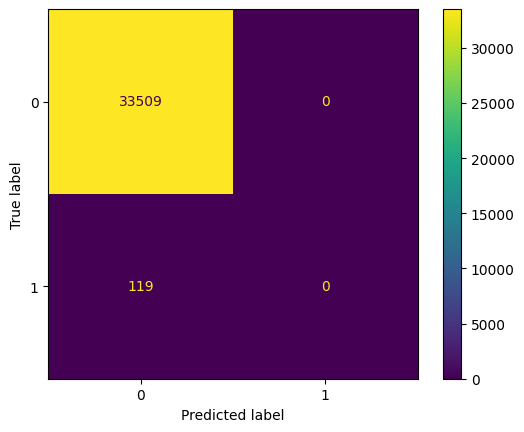

In [103]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

In [104]:
from sklearn.metrics import average_precision_score, auc

precision2, recall2, threshold = precision_recall_curve(y_test, y_pred_binary)
prauc = auc(precision2, recall2)
print("PRAUC: ", prauc)


PRAUC:  0.4982306411323897
